In [1]:
import gc
import scanit
import torch
import random
import scanpy as sc
import pandas as pd
import anndata
import numpy as np
from scipy import sparse
from sklearn.metrics import normalized_mutual_info_score, adjusted_rand_score
from sklearn.cluster import SpectralClustering, KMeans
import matplotlib.pyplot as plt
import stlearn as st
from pathlib import Path

2022-09-18 08:39:31.336674: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-18 08:39:31.336710: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


somde_preprocess

In [2]:
datadir = '/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon'
adata = sc.read_h5ad(f'{datadir}/V1_Mouse_Brain_Sagittal_Posterior.h5ad')

In [4]:
adata.X.toarray()


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 6.],
       [0., 0., 0., ..., 0., 0., 2.],
       ...,
       [0., 0., 0., ..., 0., 0., 7.],
       [0., 0., 0., ..., 0., 0., 2.],
       [0., 0., 0., ..., 0., 0., 2.]], dtype=float32)

In [5]:
from somde import SomNode
pts = adata.obsm['spatial']
df_sp = pd.DataFrame(data=adata.X.toarray(), columns=list(adata.var_names))
df_sp


,Xkr4,Gm1992,Gm19938,Gm37381,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1,...,Gm16367,AC163611.1,AC163611.2,AC140365.1,AC124606.2,AC124606.1,AC133095.2,AC133095.1,AC234645.1,AC149090.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3350,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
3351,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
3352,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7.0
3353,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0


In [6]:
som = SomNode(pts, 5)
som

using 25*25 SOM nodes for 3355 points


In [7]:
ndf,ninfo = som.mtx(df_sp.T)
nres = som.norm()
result, SVnum =som.run()
result.to_csv('./somde_result.csv')

Models: 100%|██████████| 10/10 [1:45:25<00:00, 632.56s/it] 


process

In [8]:
sp_datadir = '/home/workspace2/zhaofangyuan/data_h5ad/without_groundtruth/Visium_demon'

In [9]:
adata=sc.read_h5ad(f'{sp_datadir}/V1_Mouse_Brain_Sagittal_Posterior.h5ad')
adata

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [10]:
adata.shape

(3355, 32285)

In [14]:
n_sv_genes = 3000
adata_sp = adata.copy()
sc.pp.normalize_total(adata_sp)
df_somde = pd.read_csv('./somde_result.csv')
sv_genes = list( df_somde['g'].values[:n_sv_genes] )

# adata_sp = adata_sp[:, sv_genes]
sc.pp.log1p(adata_sp)
sc.pp.scale(adata_sp)

In [15]:
adata_sp

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'log1p'
    obsm: 'spatial'

In [16]:
scanit.tl.spatial_graph(adata_sp, method='alpha shape', alpha_n_layer=2, knn_n_neighbors=5)
scanit.tl.spatial_representation(adata_sp, n_h=30, n_epoch=2000, lr=0.001, device='cuda', n_consensus=1, projection='mds', 
    python_seed=0, torch_seed=0, numpy_seed=0)

Epoch: 000, Loss: 1.3644
Epoch: 500, Loss: 0.0014
Epoch: 1000, Loss: 0.0013
Epoch: 1500, Loss: 0.0031
Epoch: 1999, Loss: 0.0010


In [17]:
adata_sp

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'X_scanit'
    obsp: 'scanit-graph'

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'scanit_leiden_1', 'scanit_leiden_2', 'scanit_leiden_3', 'scanit_leiden_4', 'scanit_leiden_5', 'scanit_leiden_6', 'scanit_leiden_7', 'scanit_leiden_8', 'scanit_leiden_9', 'scanit_leiden_10'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'X_scanit'
    obsp: 'scanit-graph'

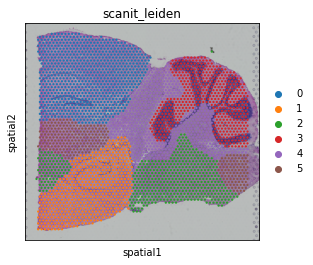

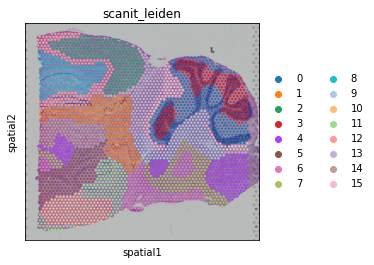

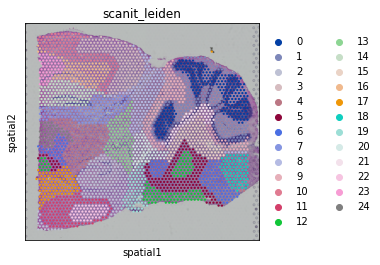

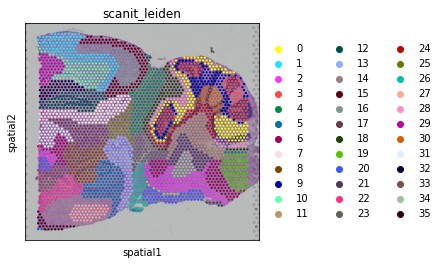

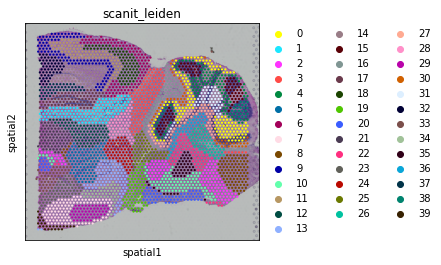

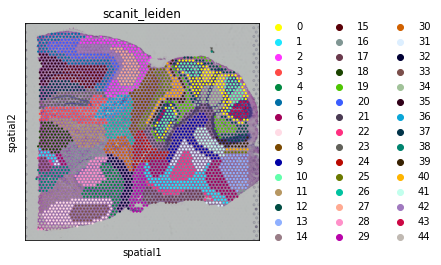

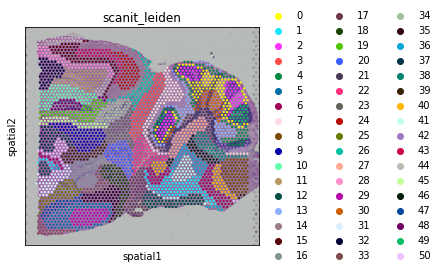

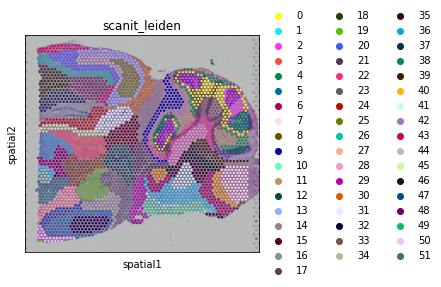

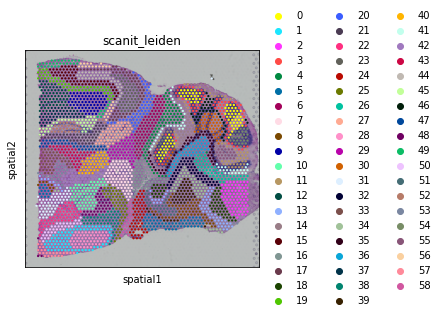

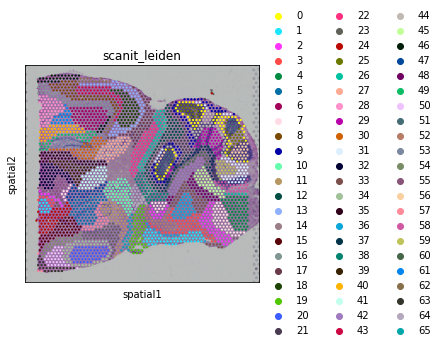

In [19]:
# sc.pp.neighbors(adata_sp, n_neighbors=15)
for i in range(10):
    adata_sp_copy=adata_sp.copy()
    resolution_list=[0.1,0.5,1,1.5,2,2.5,3,3.5,4,4.5]
    sc.pp.neighbors(adata_sp_copy, use_rep='X_scanit', n_neighbors=15)
    sc.tl.leiden(adata_sp_copy, key_added="scanit_leiden", resolution=resolution_list[i])
    sc.pl.spatial(adata_sp_copy, color='scanit_leiden', show=False)

    plt.savefig(f'./scanit_leiden_plot_{i+1}.jpg', bbox_inches='tight', dpi=150)
    adata_sp.obs['scanit_leiden_{}'.format(i+1)]=adata_sp_copy.obs['scanit_leiden']
    # adata_sedr_copy.write(f'{params.save_path}/SEDR_V1_Mouse_Brain_Sagittal_Posterior_{i+1}.h5ad')

adata_sp.write(f'./SEDR_V1_Mouse_Brain_Sagittal_Posterior(resolution).h5ad')

adata_sp


In [20]:
adata_sp

AnnData object with n_obs × n_vars = 3355 × 32285
    obs: 'in_tissue', 'array_row', 'array_col', 'scanit_leiden_1', 'scanit_leiden_2', 'scanit_leiden_3', 'scanit_leiden_4', 'scanit_leiden_5', 'scanit_leiden_6', 'scanit_leiden_7', 'scanit_leiden_8', 'scanit_leiden_9', 'scanit_leiden_10'
    var: 'gene_ids', 'feature_types', 'genome', 'mean', 'std'
    uns: 'spatial', 'log1p'
    obsm: 'spatial', 'X_scanit'
    obsp: 'scanit-graph'